In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/real-life-violence-situations-dataset


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras import models
from keras._tf_keras.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
import random

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU Memory Growth Enabled")
    except RuntimeError as e:
        print(e)

GPU Memory Growth Enabled


In [4]:
os.listdir(path)

['real life violence situations', 'Real Life Violence Dataset']

In [5]:
path = os.path.join(path, 'Real Life Violence Dataset')

In [6]:
os.listdir(path)

['NonViolence', 'Violence']

In [7]:
violence_dataset = os.path.join(path, 'Violence')

non_violence_dataset = os.path.join(path, 'NonViolence')

In [8]:
def extract_frames(video_path, skip_frames=7):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return None

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % skip_frames == 0:

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            resized_frame = cv2.resize(frame, (128, 128))

            normalize_frames = resized_frame.astype('float32') / 255.0

            frames.append(normalize_frames)

        frame_count += 1

    cap.release()

    return frames

In [9]:
violance_frames = []

non_violance_frames = []

In [10]:
all_filenames = [f for f in os.listdir(violence_dataset) if f.endswith('.mp4')]

for filename in all_filenames[:100]:
    video_path = os.path.join(violence_dataset, filename)
    frames = extract_frames(video_path)
    violance_frames.extend(frames)


In [11]:
all_non_violent_files = [f for f in os.listdir(non_violence_dataset) if f.endswith('.mp4')]

for filename in all_non_violent_files[:100]:
    video_path = os.path.join(non_violence_dataset, filename)
    frames = extract_frames(video_path)
    non_violance_frames.extend(frames)


In [12]:
violance_frames_labels = np.ones(len(violance_frames))

non_violance_frames_labels = np.zeros(len(non_violance_frames))

In [13]:
def plot_sample_frames(frames, title, num_samples=3):
    if not frames:
        print(f"No frames available for {title}")
        return

    num_samples = min(num_samples, len(frames))
    sampled_frames = random.sample(frames, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    if num_samples == 1:
        axes = [axes]

    for i, frame in enumerate(sampled_frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (128, 128))
        axes[i].imshow(frame)
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

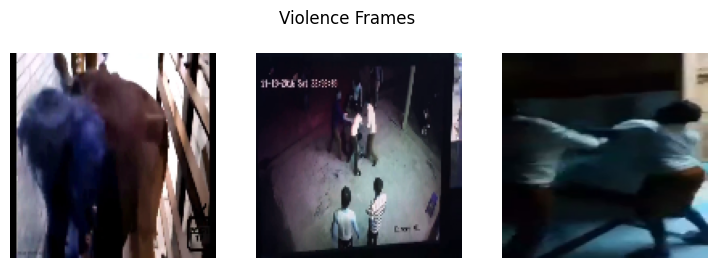

In [14]:
plot_sample_frames(violance_frames, "Violence Frames", num_samples=3)

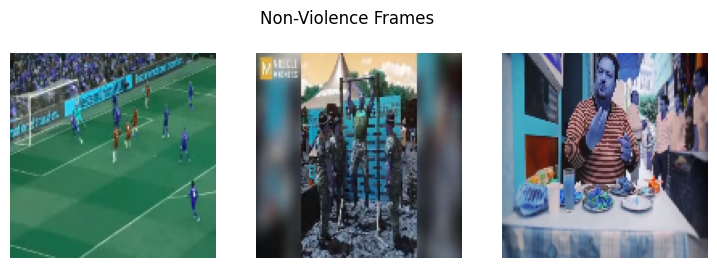

In [15]:
plot_sample_frames(non_violance_frames, "Non-Violence Frames", num_samples=3)

In [16]:
print(len(violance_frames), len(non_violance_frames))
print(type(violance_frames[0]), violance_frames[0].shape)
print(type(non_violance_frames[0]), non_violance_frames[0].shape)

2110 1828
<class 'numpy.ndarray'> (128, 128, 3)
<class 'numpy.ndarray'> (128, 128, 3)


In [19]:
matrix = np.array(violance_frames + non_violance_frames)
labels = np.concatenate([violance_frames_labels, non_violance_frames_labels])

In [20]:
x_train, x_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, random_state=42)

In [108]:
from tensorflow.keras import layers, models, Input

def cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(8, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [109]:
INPUT_SHAPE = (128, 128, 3)

model = cnn_model(INPUT_SHAPE)

In [110]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,073 (941.69 KB)

 Trainable params: 241,073 (941.69 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [128]:
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test), verbose="auto")

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7706 - loss: 0.4580 - val_accuracy: 0.7449 - val_loss: 0.4669
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7542 - loss: 0.4586 - val_accuracy: 0.8008 - val_loss: 0.4228
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7707 - loss: 0.4445 - val_accuracy: 0.8135 - val_loss: 0.3883
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8124 - loss: 0.3877 - val_accuracy: 0.8477 - val_loss: 0.3377
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8290 - loss: 0.3815 - val_accuracy: 0.8807 - val_loss: 0.2856
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8478 - loss: 0.3220 - val_accuracy: 0.8756 - val_loss: 0.2701
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8533 - loss: 0.3089 - val_accuracy: 0.8832 - val_loss: 0.2797
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8652 - loss: 0.3150 - val_accuracy: 0.8871 - v

In [129]:
model.evaluate(x_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9728 - loss: 0.1026


[0.09244533628225327, 0.9733502268791199]

In [130]:
y_pred = model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [131]:
classification_report(y_test, y_pred_labels)

'              precision    recall  f1-score   support\n\n         0.0       0.98      0.96      0.97       353\n         1.0       0.97      0.98      0.98       435\n\n    accuracy                           0.97       788\n   macro avg       0.97      0.97      0.97       788\nweighted avg       0.97      0.97      0.97       788\n'

In [132]:
cm = metrics.confusion_matrix(y_test, y_pred_labels)

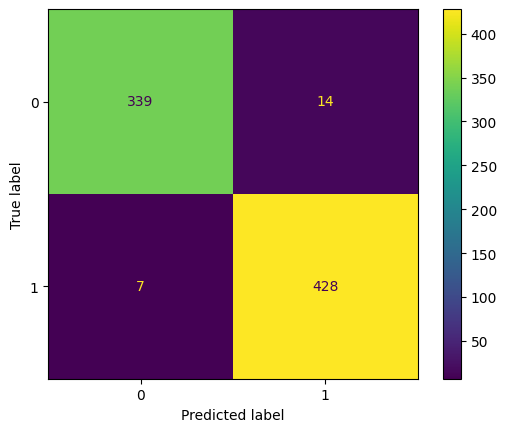

In [133]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

cm_display.plot()

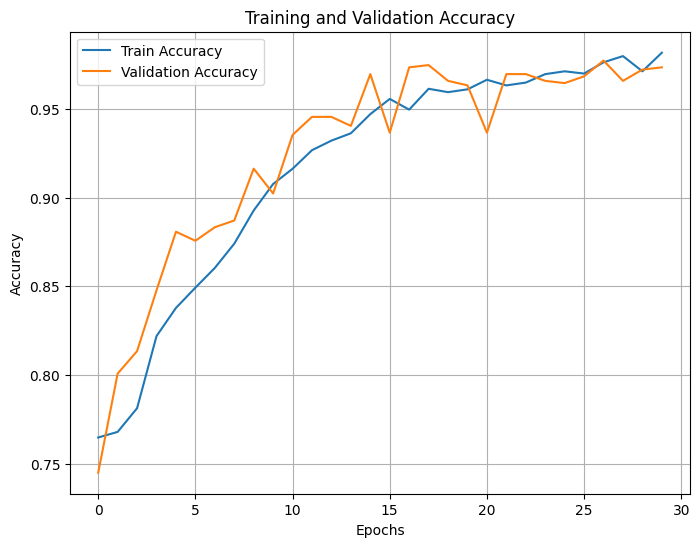

In [134]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

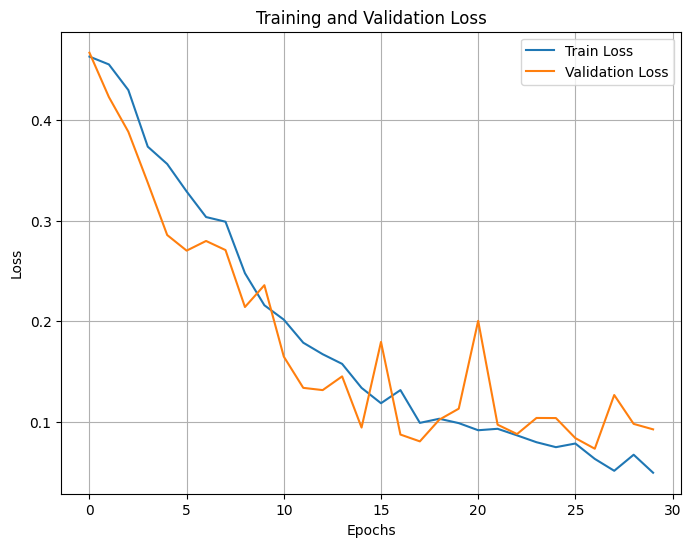

In [135]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [136]:
pip install shap lime opencv-python matplotlib scikit-image tf-keras-vis


In [137]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

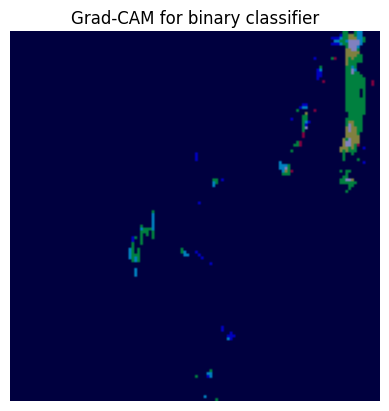

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

def preprocess_image_array(img_array):
    img_array = tf.image.resize(img_array, (128, 128))
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

img = preprocess_image_array(violance_frames[55])

gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

score = lambda output: output[:, 0]

cam = gradcam(score, img, penultimate_layer=-1)

heatmap = np.uint8(255 * cam[0])

plt.imshow(tf.cast(tf.squeeze(img, axis=0), tf.uint8))
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM for binary classifier")
plt.axis('off')
plt.show()


In [144]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [145]:
def preprocess_image(img):
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0
    return tf.expand_dims(img, axis=0)

def deprocess_image(img):
    img = img - tf.reduce_min(img)
    img = img / tf.reduce_max(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)
    return img[0]


In [146]:
@tf.function
def deepdream_step(img, model, layer_name, step_size):
    dream_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    with tf.GradientTape() as tape:
        tape.watch(img)
        activations = dream_model(img)
        loss = tf.reduce_mean(activations)

    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img = img + gradients * step_size
    img = tf.clip_by_value(img, -1.0, 1.0)

    return img


In [147]:
def run_deep_dream(model, input_image, layer_name='conv2d_1', steps=100, step_size=0.01):
    img = preprocess_image(input_image)
    for step in range(steps):
        img = deepdream_step(img, model, layer_name, step_size)
    result = deprocess_image(img)
    return result


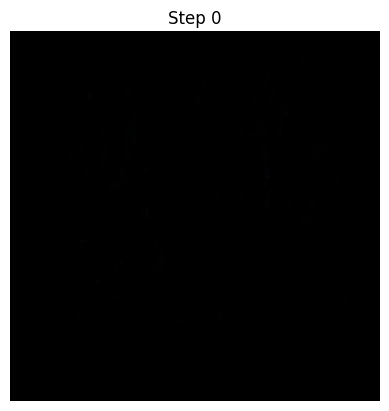

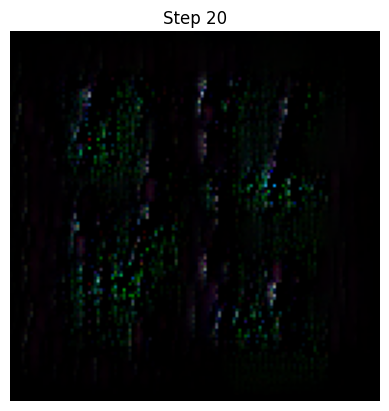

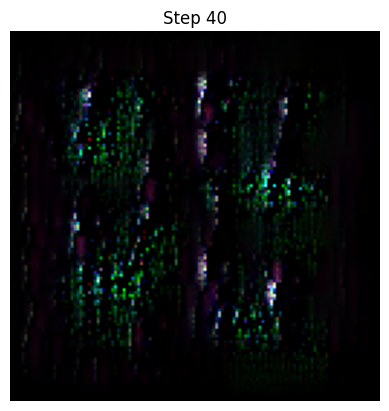

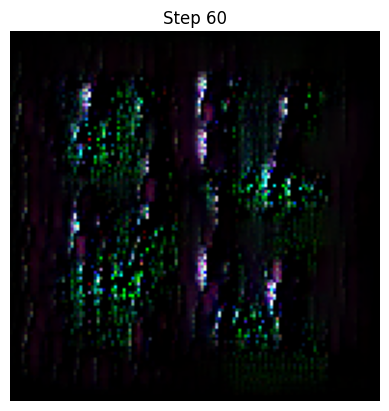

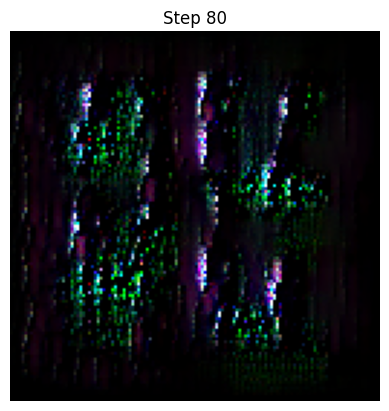

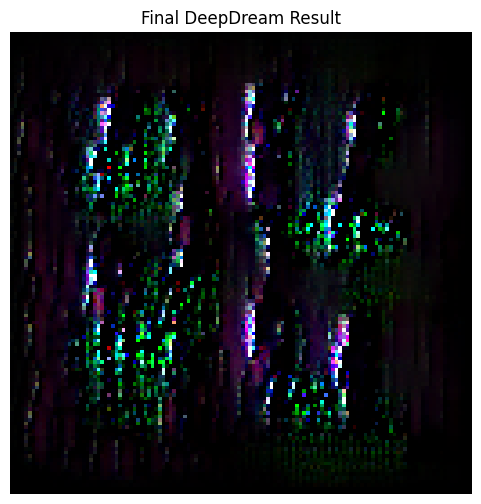

In [150]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img):
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0
    return tf.expand_dims(img, axis=0)

def deprocess_image(img):
    img = (img + 1.0) * 127.5
    img = tf.clip_by_value(img, 0.0, 255.0)
    img = tf.cast(img, tf.uint8)
    return img[0]

@tf.function
def deepdream_step(img, model, layer_name, step_size):
    dream_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    with tf.GradientTape() as tape:
        tape.watch(img)
        activations = dream_model(img)
        loss = tf.reduce_mean(activations)

    grads = tape.gradient(loss, img)

    grads = grads / (tf.math.reduce_std(grads) + 1e-8)

    img = img + step_size * grads
    img = tf.clip_by_value(img, -1.0, 1.0)

    return img

def run_deep_dream(model, input_img, layer_name='dense_8', steps=100, step_size=0.01):
    img = preprocess_image(input_img)

    for step in range(steps):
        img = deepdream_step(img, model, layer_name, step_size)

        if step % 20 == 0:
            result = deprocess_image(img)
            plt.imshow(result)
            plt.title(f"Step {step}")
            plt.axis('off')
            plt.show()

    final_result = deprocess_image(img)
    return final_result

input_image = violance_frames[55]

dream_result = run_deep_dream(model, input_image, layer_name='max_pooling2d_9', steps=100, step_size=0.01)

plt.figure(figsize=(6, 6))
plt.imshow(dream_result)
plt.title("Final DeepDream Result")
plt.axis('off')
plt.show()


In [151]:
import numpy as np
import lime
from lime import lime_image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.segmentation import mark_boundaries


In [152]:
input_image = violance_frames[55]

input_image = np.expand_dims(input_image, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━

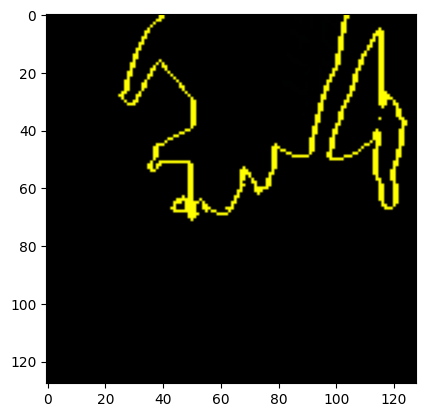

In [153]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(input_image[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=5, hide_rest=True)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.show()